# Data exploration
Halo reports from four Minneapolis public schools: Camden (Henry in the dataset), Anwatin, Anderson, and Roosevelt

## Cleaning

In [60]:
import pandas as pd
from datetime import datetime

csv_files = ['haloreport-2024-09-02-2024-12-02-copy.csv', 'haloreport-2024-12-03-2025-02-03-copy.csv', 'haloreport-2025-02-03-2025-03-03-copy.csv', 'haloreport-2025-03-04-2025-04-15-copy.csv']
df = pd.DataFrame()

for file in csv_files:
    x = pd.read_csv(file)
    print(f'File has {x.shape[0]} rows')
    x['Date'] = pd.to_datetime(x['Date'], format='%m/%d/%Y')
    df = pd.concat([df, x], ignore_index=True)

print(f'Combined file has {df.shape[0]} rows')

File has 30277 rows
File has 777 rows
File has 5730 rows
File has 9040 rows
Combined file has 45824 rows


In [62]:
df.head()

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration
0,1st Floor B130 All Gender,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,2024-11-02 07:09:39,2024-11-02 07:10:19,1730549379,126.16,Andersen,40.0
1,1st Floor B130 All Gender,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,2024-11-02 07:11:41,2024-11-02 07:12:11,1730549501,64.52,Andersen,30.0
2,1st Floor B130 All Gender,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,2024-11-02 07:39:22,2024-11-02 07:39:52,1730551162,40.88,Andersen,30.0
3,1st Floor B130 All Gender,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,2024-11-02 09:58:32,2024-11-02 09:59:02,1730559512,49.40,Andersen,30.0
4,1st Floor B130 All Gender,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,2024-11-02 09:59:28,2024-11-02 09:59:58,1730559568,54.58,Andersen,30.0


In [61]:
# Transform the dataset
df['School'] = df['Device'].apply(lambda x: x.split('_')[0])
df['Site'] = df['Device'].apply(lambda x: ' '.join(x.split('_')[1:]))
# Combine 'Date' with 'Start Time' and 'Stop Time'
df['Start Time'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Start Time'], format='%Y-%m-%d %I:%M:%S %p')
df['Stop Time'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Stop Time'], format='%Y-%m-%d %I:%M:%S %p')
df['Duration'] = (df['Stop Time'] - df['Start Time']).dt.total_seconds()

In [63]:
df.to_csv('cleaned_halo_data.csv', index=False)

In [54]:
df.Device.unique()

array(['Andersen_1st_Floor_B130_All_Gender',
       'Andersen_2nd__Floor__C226_All_Gender',
       'Andersen_2nd_Floor_B226_All_Gender',
       'Andersen_2nd_Floor_Boys_D223_SE_Round',
       'Andersen_2nd_Floor_D201_Boys_SW_Round',
       'Andersen_2nd_Floor_D202_Girls_SW_Round',
       'Andersen_2nd_Floor_Girls_D221_SE_Round', 'Anwatin_Boys_407_#1',
       'Anwatin_Boys_407_#2', 'Anwatin_Girls_209_#1',
       'Anwatin_Girls_209_#2', 'Anwatin_Girls_418_#1',
       'Anwatin_Girls_418_#2',
       'Henry_1st_floor_stair_1_NW_Boys_restrooms',
       'Henry_1st_Floor_Stair_12_NE_Girls_Restrooms',
       'Henry_2nd_Floor_Stair_1_NW_Restroom_#3',
       'Henry_2nd_Floor_Stair_12_NE_Restrooms_#1',
       'Henry_2nd_Floor_Stair_14_SW_Restrooms_#1',
       'Henry_3RD_Floor_Stair_1_NW_Restroom_#1',
       'Henry_3rd_Floor_Stair_12_NE_Restrooms_#1',
       'Henry_3rd_Floor_Stair_14_SW_Restroom_#1',
       'Roosevelt_1st_floor_144_North_Sensor',
       'Roosevelt_1st_floor_144_South__Sensor',
    

## Exploratory analysis

In [86]:
# Read the csv and segment by school
df = pd.read_csv('cleaned_halo_data.csv')
andersen_df = df[df['School'] == 'Andersen']
anwatin_df = df[df['School'] == 'Anwatin']
camden_df = df[df['School'] == 'Henry']
roosevelt_df = df[df['School'] == 'Roosevelt']

In [77]:
# Get some basic stats by school
alert_count = df.School.value_counts()
device_count = df.groupby(by='School').Device.nunique()
meta = pd.DataFrame({'alert_count': alert_count, 'device_count': device_count})
meta

,alert_count,device_count
School,,
Andersen,2107,8
Anwatin,786,7
Henry,21415,8
Roosevelt,21516,6


### General functions

In [148]:
# Graph: alert count by day
import seaborn as sns
import matplotlib.pyplot as plt

def alert_count_by_day(df, save_path=None):
    date_counts = df.Date.value_counts(sort=False)
    
    plt.figure(figsize=(18, 6))
    sns.barplot(x=date_counts.index, y=date_counts.values)

    plt.title(f'{df.School.unique()[0]} Alert Count by Day', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Alert Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [160]:
# Graph: grouped alert count by day
import seaborn as sns
import matplotlib.pyplot as plt

def grouped_alert_count_by_day(df, group, save_path=None):
    # Group by 'Date' and the specified 'group', then count occurrences
    date_counts = df.groupby(['Date', group]).size().reset_index(name='count')
    
    plt.figure(figsize=(18, 6))
    sns.barplot(x='Date', y='count', hue=group, data=date_counts, palette='Set2')
    plt.legend()

    plt.title(f'{df.School.unique()[0]} Grouped Alert Count by Day', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Alert Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

### Andersen

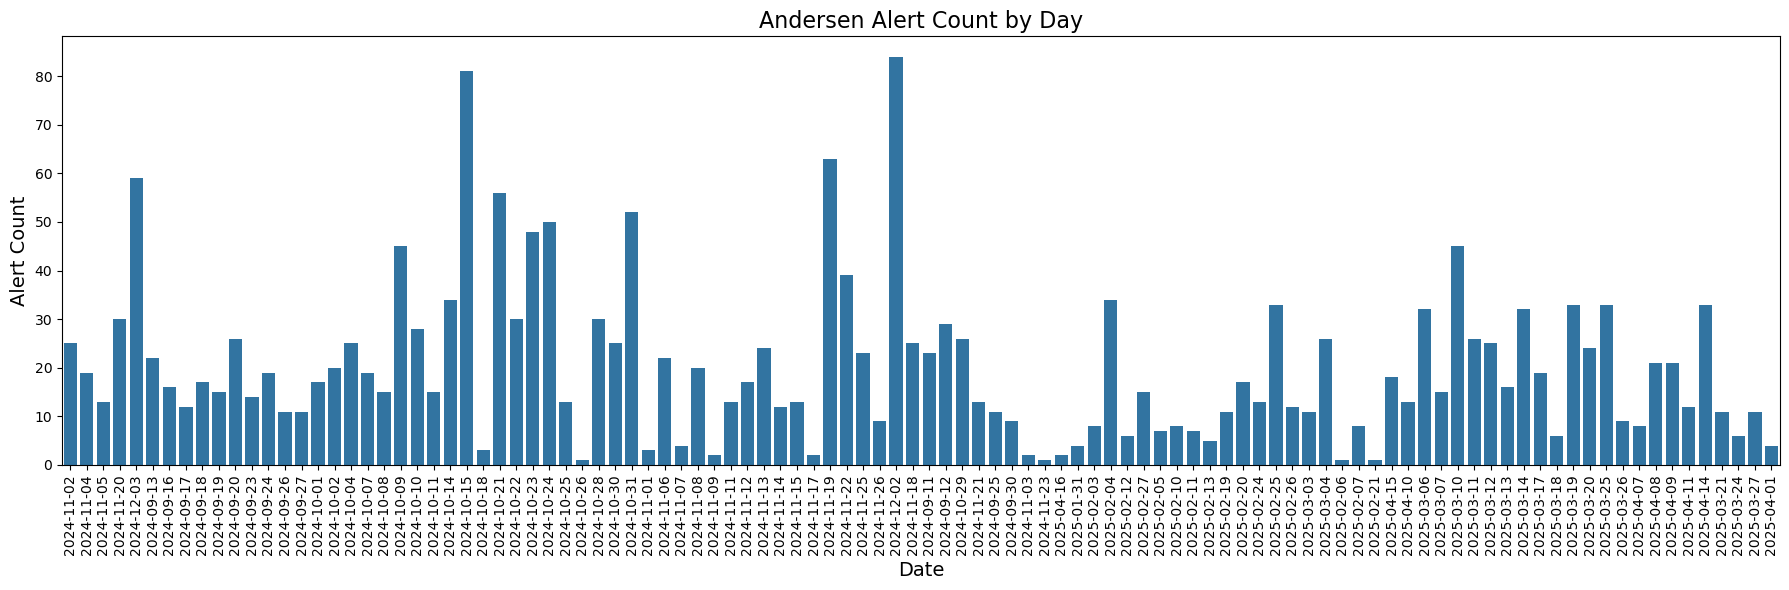

In [149]:
alert_count_by_day(andersen_df)

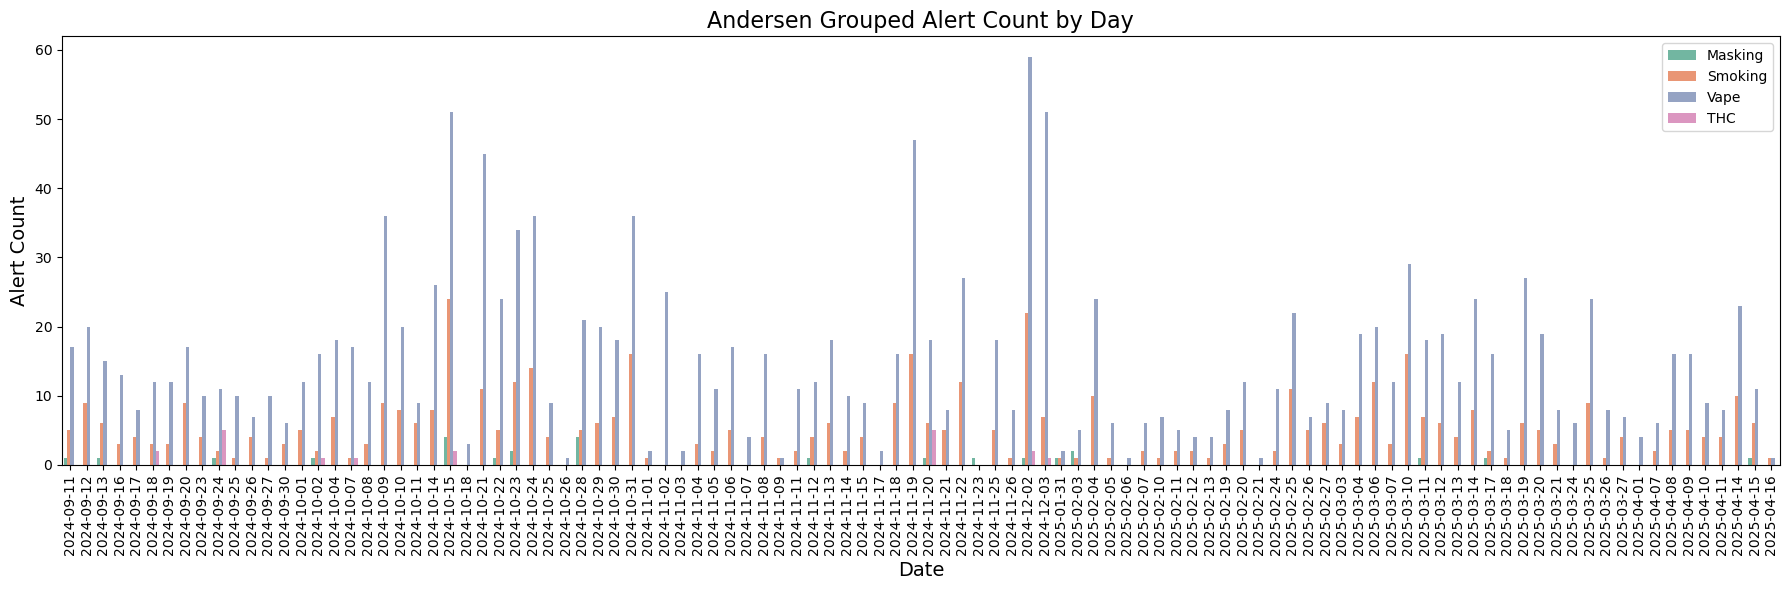

In [156]:
grouped_alert_count_by_day(andersen_df, 'Type')

### Anwatin

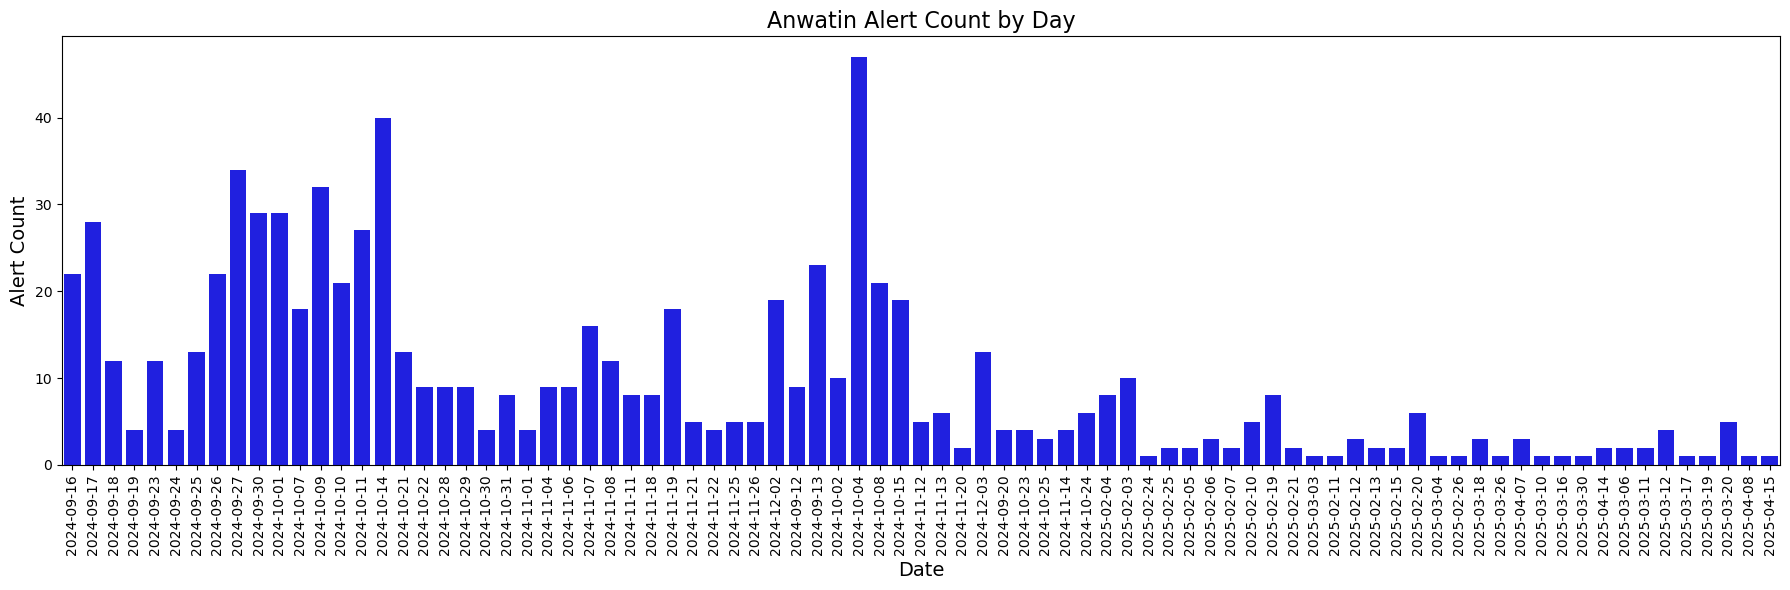

In [106]:
alert_count_by_day(anwatin_df)

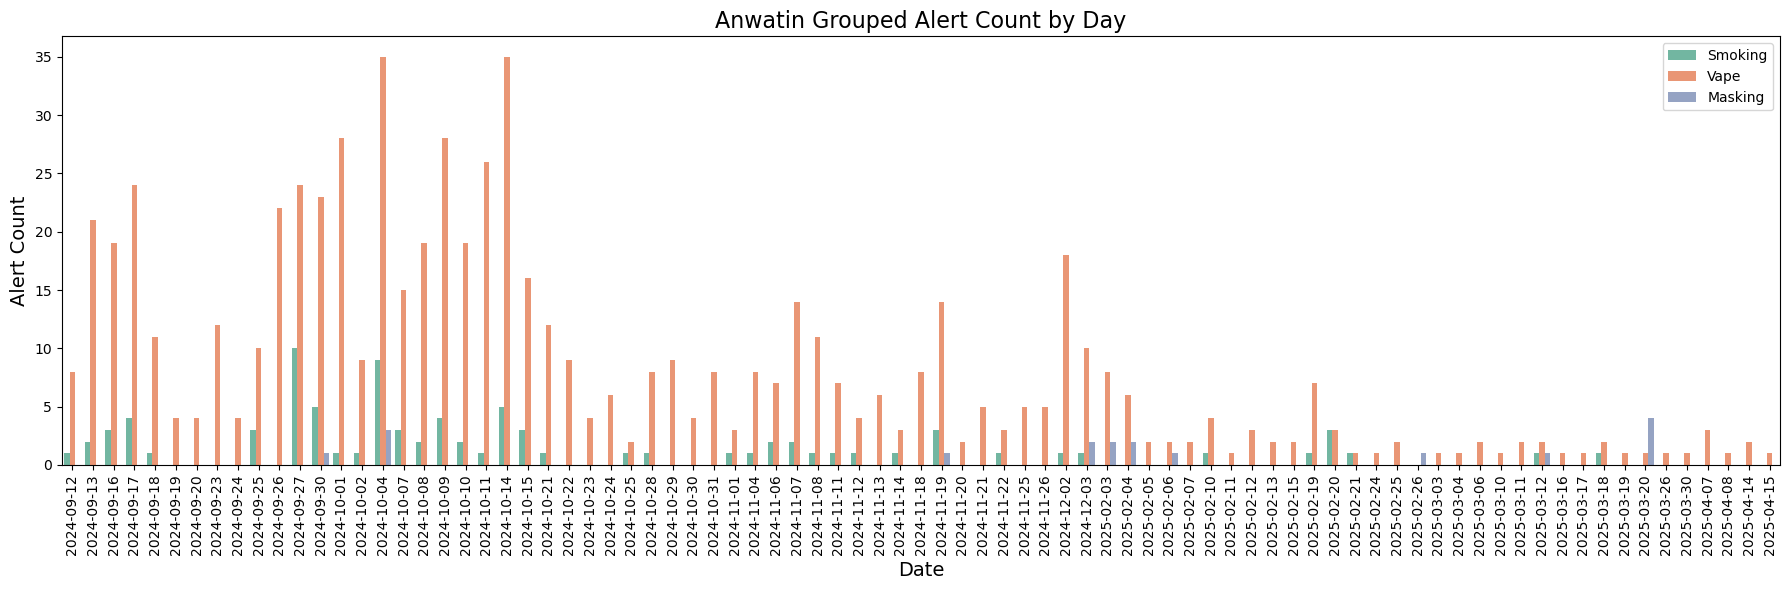

In [157]:
grouped_alert_count_by_day(anwatin_df, 'Type')

### Camden (Henry)

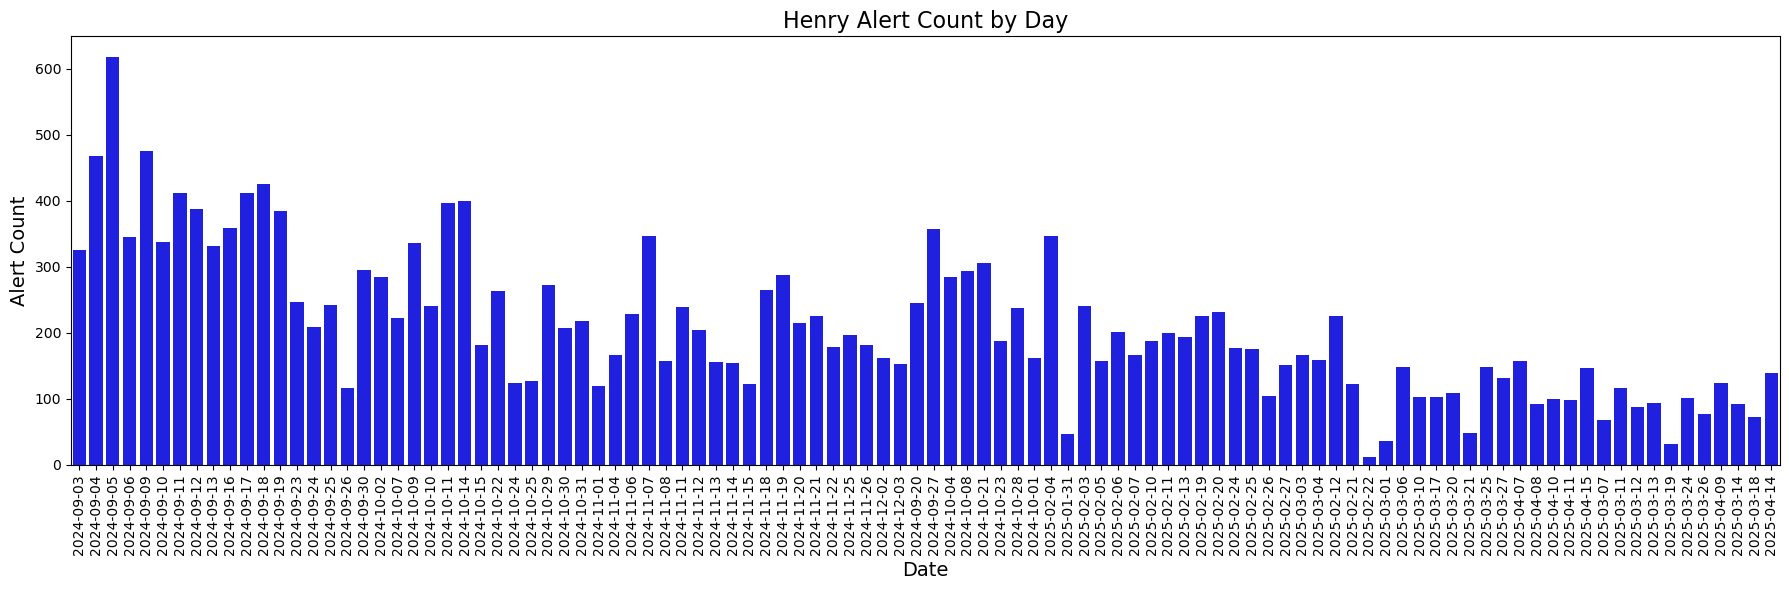

In [107]:
alert_count_by_day(camden_df)

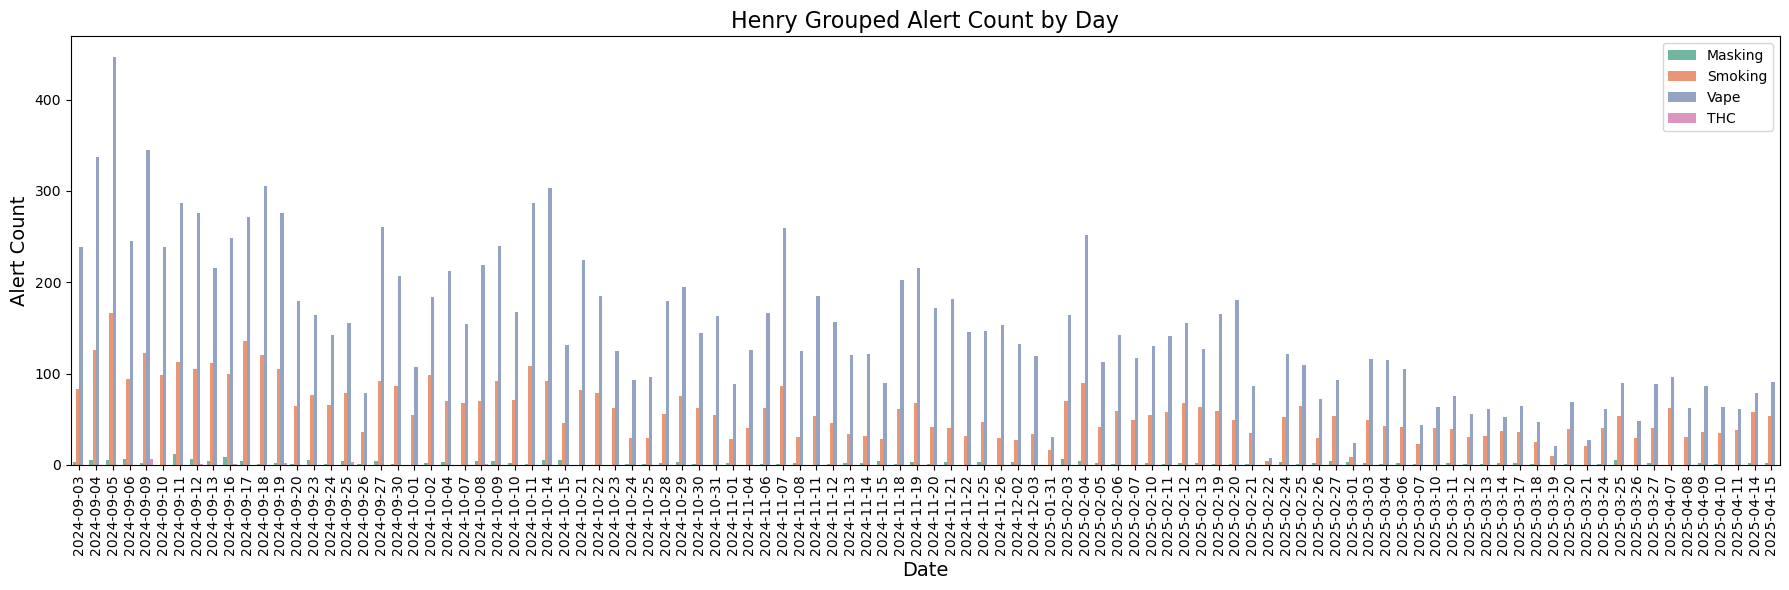

In [158]:
grouped_alert_count_by_day(camden_df, 'Type')

### Roosevelt

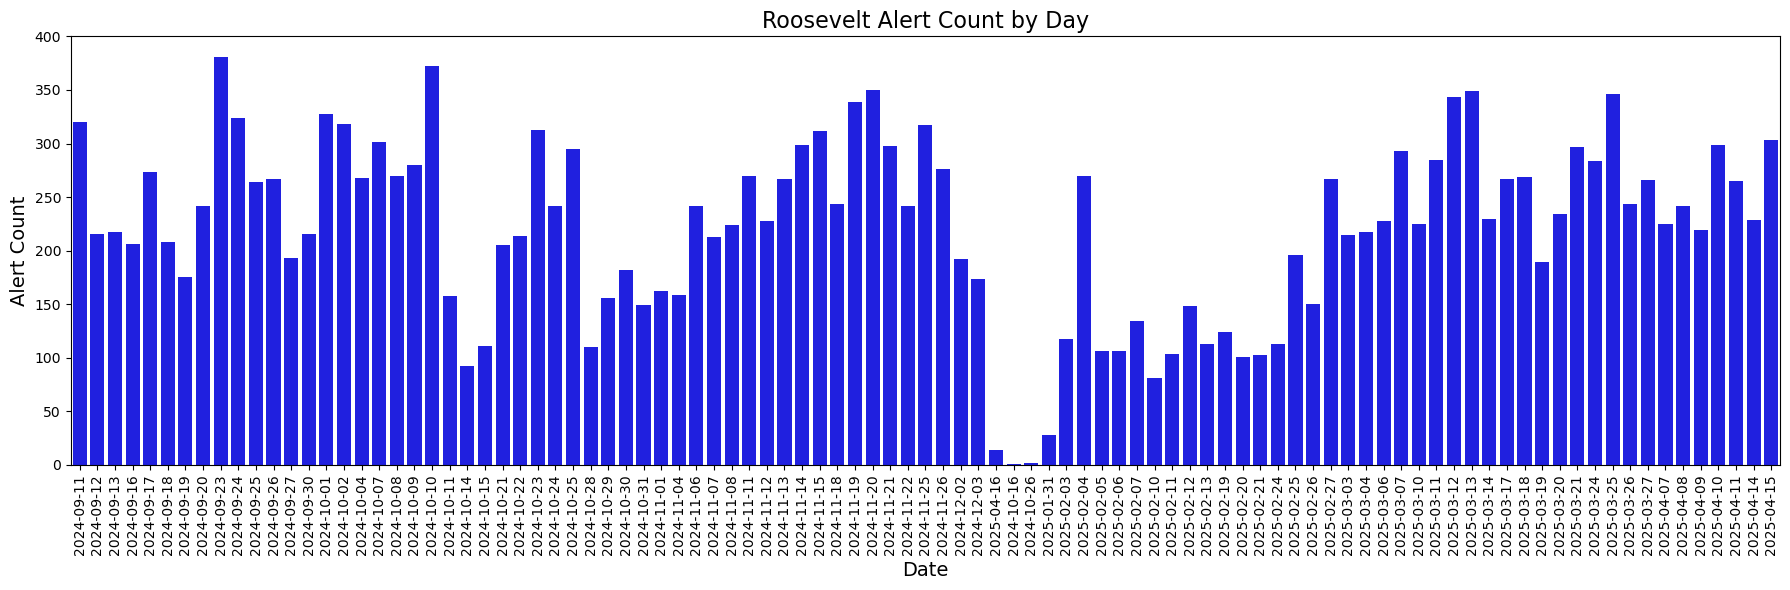

In [108]:
alert_count_by_day(roosevelt_df)

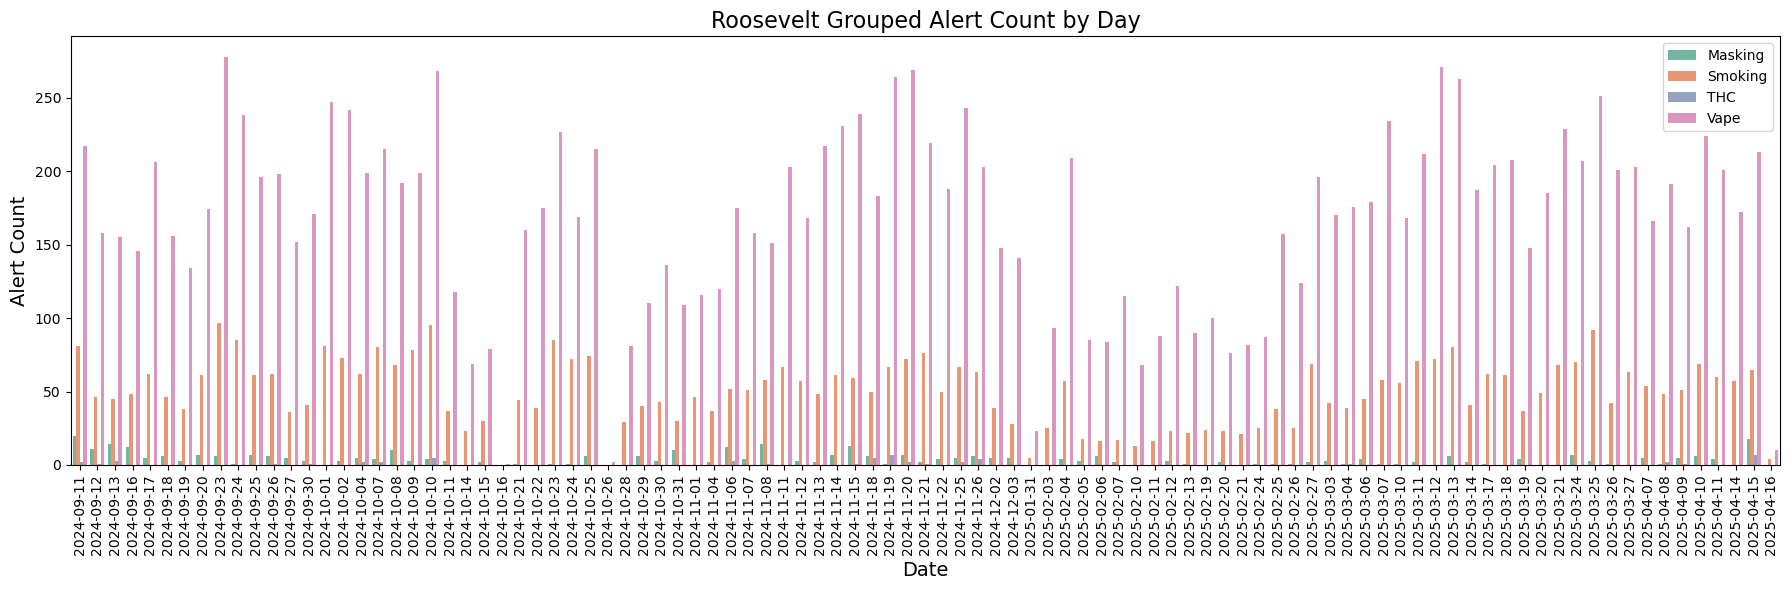

In [159]:
grouped_alert_count_by_day(roosevelt_df, 'Type')